# Musical Instrument Recognition  (Single-Label Classification)

# Importing Packages

In [ ]:
# load libraries
import sys
import os
import numpy as np
import librosa
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt

# Global Settings


In [ ]:
# download the dataset file
!gdown --id 1rGXx_f-4VlSXJIje7DaCBl38dl14GwWX

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1rGXx_f-4VlSXJIje7DaCBl38dl14GwWX
From (redirected): https://drive.google.com/uc?id=1rGXx_f-4VlSXJIje7DaCBl38dl14GwWX&confirm=t&uuid=76cf7b83-af1b-491e-9d1f-39030b50afaa
To: /content/gct634_nsynth.zip
100% 130M/130M [00:02<00:00, 57.9MB/s]


In [ ]:
# uncompress the zip file
!unzip gct634_nsynth.zip

In [ ]:

# Change this data path with your own local path
data_path = './drive/MyDrive/gct634_nsynth/'

# path to store MFCC
mfcc_path = './nsynth_features/mfcc/'

MFCC_DIM = 20

NUM_TRAIN = 1100
NUM_VALID = 300


# Feature Extraction

In [ ]:
def extract_mfcc(dataset='train'):
    f = open(data_path + dataset + '_list.txt','r')

    i = 0
    for file_name in f:
        # progress check
        i = i + 1
        if not (i % 10):
            if dataset == 'train':
              print("\r {:.2f}%".format(i/NUM_TRAIN*100), end='')
            elif dataset == 'valid':
              print("\r {:.2f}%".format(i/NUM_VALID*100), end='')

        # load audio file
        file_name = file_name.rstrip('\n')
        file_path = data_path + file_name
        y, sr = librosa.load(file_path, sr=22050)

        ##### Method 1
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=MFCC_DIM)

        ##### Method 2
        """
        # STFT
        S = librosa.core.stft(y, n_fft=1024, hop_length=512, win_length=1024)

        # power spectrum
        D = np.abs(S)**2

        # mel spectrogram (512 --> 40)
        mel_basis = librosa.filters.mel(sr, 1024, n_mels=40)
        mel_S = np.dot(mel_basis, D)

        #log compression
        log_mel_S = librosa.power_to_db(mel_S)

        # mfcc (DCT)
        mfcc = librosa.feature.mfcc(S=log_mel_S, n_mfcc=13)
        mfcc = mfcc.astype(np.float32)    # to save the memory (64 to 32 bits)
        """

        # save mfcc as a file
        file_name = file_name.replace('.wav','.npy')
        save_file = mfcc_path + file_name

        if not os.path.exists(os.path.dirname(save_file)):
            os.makedirs(os.path.dirname(save_file))
        np.save(save_file, mfcc)

    f.close()

In [ ]:
extract_mfcc(dataset='train')
extract_mfcc(dataset='valid')

 100.00%

# Feature Summary

In [ ]:
def mean_mfcc(dataset='train'):

    f = open(data_path + dataset + '_list.txt','r')

    if dataset == 'train':
        mfcc_mat = np.zeros(shape=(MFCC_DIM, NUM_TRAIN))
    elif dataset == 'valid':
        mfcc_mat = np.zeros(shape=(MFCC_DIM, NUM_VALID))

    i = 0
    for file_name in f:

        # load mfcc file
        file_name = file_name.rstrip('\n')
        file_name = file_name.replace('.wav','.npy')
        mfcc_file = mfcc_path + file_name
        mfcc = np.load(mfcc_file)

        # mean pooling
        temp = np.mean(mfcc, axis=1)
        mfcc_mat[:,i]= np.mean(mfcc, axis=1)
        i = i + 1

    f.close()

    return mfcc_mat


In [ ]:
train_mfcc = mean_mfcc('train')
valid_mfcc = mean_mfcc('valid')

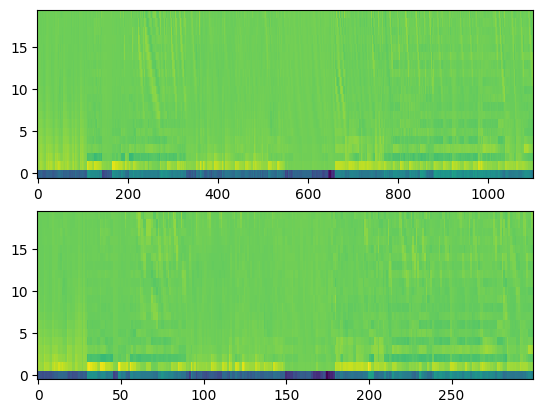

In [ ]:
plt.figure(1)
plt.subplot(2,1,1)
plt.imshow(train_mfcc, interpolation='nearest', origin='lower', aspect='auto')

plt.subplot(2,1,2)
plt.imshow(valid_mfcc, interpolation='nearest', origin='lower', aspect='auto')

plt.show()



# Data Preparation

In [ ]:
# load data
train_X = train_mfcc
valid_X = valid_mfcc

# label generation
cls = np.array([1,2,3,4,5,6,7,8,9,10])
train_Y = np.repeat(cls, int(NUM_TRAIN/10))
valid_Y = np.repeat(cls, int(NUM_VALID/10))

# feature normalizaiton
train_X = train_X.T
train_X_mean = np.mean(train_X, axis=0)
train_X = train_X - train_X_mean
train_X_std = np.std(train_X, axis=0)
train_X = train_X / (train_X_std + 1e-5)

valid_X = valid_X.T
valid_X = valid_X - train_X_mean
valid_X = valid_X/(train_X_std + 1e-5)


# ML Model Training & Validation

In [ ]:
def train_model(train_X, train_Y, valid_X, valid_Y, hyper_param1):

    # Choose a classifier (here, linear SVM)
    clf = SGDClassifier(verbose=0, loss="hinge", alpha=hyper_param1, max_iter=1000, penalty="l2", random_state=0)

    # train
    clf.fit(train_X, train_Y)

    # validation
    valid_Y_hat = clf.predict(valid_X)

    accuracy = np.sum((valid_Y_hat == valid_Y))/NUM_VALID*100.0

    return clf, accuracy


In [ ]:
# training model
alphas = [0.0001, 0.001, 0.01, 0.1, 1]

model = []
valid_acc = []

# model search
for a in alphas:
  clf, acc = train_model(train_X, train_Y, valid_X, valid_Y, a)
  model.append(clf)
  valid_acc.append(acc)

  print(f'alpha={a:.4f}, validation acc={acc:.2f}%')

# choose the model that achieve the best validation accuracy
final_model = model[np.argmax(valid_acc)]

print(f'Best validation acc={valid_acc[np.argmax(valid_acc)]:.2f}%')


alpha=0.0001, validation acc=69.33%
alpha=0.0010, validation acc=74.00%
alpha=0.0100, validation acc=72.00%
alpha=0.1000, validation acc=68.00%
alpha=1.0000, validation acc=60.67%
Best validation acc=74.00%
